# 1.1 Парсинг данных

## 1.1.1 Загрузка информации о компаниях из хабра

In [1]:
#Импорт библиотек
import pandas as pd
import numpy as np
import docx
from bs4 import BeautifulSoup as bs
import requests
import time

In [2]:
#Загрузка документа
doc = docx.Document('Condidates.docx')

In [3]:
#Запись всех компаний их файла расширения docx
company = []
for paragraph in doc.paragraphs:
    if (len(paragraph.text) > 0):
        company.append(paragraph.text)

In [4]:
#1-ый словарь для компаний находящиеся в хабре 
result_list = {'name_company':[], 'description_company':[], 'rating_company':[], 'activity_company':[]}

In [5]:
for com in company:
        if (' ' in com):
            com = com.replace(' ', '%20')
        url = "https://habr.com/ru/companies/?q=" + com        #Поиск компаний в хабре
        page = requests.get(url, timeout=10)
        soup = bs(page.text, 'html.parser')
        name_company = soup.find('em', class_='searched-item') #Получаем имя компании
        if name_company is not None:
            href = soup.find('a', class_='tm-company-snippet__title')
            url = 'https://habr.com' + href.get('href')
            page = requests.get(url)
            soup = bs(page.text, 'html.parser')
            
            #Находим на странице описание компании
            description_company = soup.find('span', class_='tm-company-profile__content') 
            
            #Находим на странице рейтинг компании
            rating_company = soup.find('span', class_='tm-votes-lever__score-counter tm-votes-lever__score-counter tm-votes-lever__score-counter_rating') 
            
            #Находим на странице сферы деятельности компании
            activity_company = soup.find_all('span', class_='tm-company-profile__categories-wrapper') 
            
            #Добавляем данные в словарь
            result_list['name_company'].append(name_company.text)
            result_list['description_company'].append(description_company.text)
            result_list['rating_company'].append(rating_company.text.strip())
            activities = []
            for activity in activity_company:
                activities.append(activity.text.strip())        
            result_list['activity_company'].append(", ".join(activities))

In [6]:
#Записываем словарь в csv файл
FILE_NAME = "habr.csv"
df = pd.DataFrame.from_dict(data=result_list, orient="index")
df.to_csv(FILE_NAME)
df = df.transpose()

In [7]:
df.head()

name_company                                description_company  \
0     Skillbox  Образовательная платформа Skillbox — один из л...   
1      Иннотех  Мы мыслим инновациями\n\r\nГруппа «Иннотех» — ...   
2    Нетология  Нетология — платформа профессионального роста....   

  rating_company                                   activity_company  
0         119.84  Веб-разработка, Дизайн и юзабилити, Реклама и ...  
1          27.67  Веб-разработка, Программное обеспечение, Веб-с...  
2          73.64  Веб-разработка, Дизайн и юзабилити, Реклама и ...

Из всех компаний присутствующих в документе на хабре присутствуют только 4: "Skillbox", "Иннотех", "СберМаркет", "Нетология"

## 1.1.2 Загрузка информации о компаниях из json файлов

In [8]:
#Импортируем библиотеки для работы с файлами формата json
import os 
import glob
import json

In [9]:
#Получаем из директории все файлы формата json
all_json = glob.glob(r"Data\*json")

In [10]:
result_list2 = {'name_company':[], 'description_company':[], 'rating_company':[], 'activity_company':[], 'date_publish':[], 'text':[]}
for js in all_json:
#Если компания из json файлов присутствует в 1-ом словаре, то добавляем к ним дату публикации и текст статей
    if js.split("\\")[1][:-5] in result_list['name_company']: 
        with open(js, 'r', encoding='utf-8') as jsonData:
            data = json.load(jsonData)
            for ref in data['refs']:
                if (ref != None):
                    result_list2['name_company'].append(js.split("\\")[1][:-5])
                    result_list2['description_company'].append(result_list['description_company'][result_list['name_company'].index(js.split("\\")[1][:-5])])
                    result_list2['rating_company'].append(result_list['rating_company'][result_list['name_company'].index(js.split("\\")[1][:-5])])
                    result_list2['activity_company'].append(result_list['activity_company'][result_list['name_company'].index(js.split("\\")[1][:-5])])
                    result_list2['date_publish'].append(ref[1]['day'] + ' ' + ref[1]['month'])
                    result_list2['text'].append(ref[0])
#Если компания из json файлов не присутствует в 1-ом словаре, то добавляем её к имеющимся данным (вместе с данными статей)
    else:
        with open(js, 'r', encoding='utf-8') as jsonData:
            data = json.load(jsonData)
            for ref in data['refs']:
                if (ref != None):
                    result_list2['name_company'].append(js.split("\\")[1][:-5])
                    result_list2['description_company'].append(None)
                    result_list2['rating_company'].append(None)
                    result_list2['activity_company'].append(None)
                    result_list2['date_publish'].append(ref[1]['day'] + ' ' + ref[1]['month'])
                    result_list2['text'].append(ref[0])

In [11]:
#Записываем словарь в csv файл
FILE_NAME = "habr.csv"
df = pd.DataFrame.from_dict(data=result_list2, orient="index")
df.to_csv(FILE_NAME)
df = df.transpose()

In [12]:
df.head()

name_company description_company rating_company activity_company  \
0  Cybersport.Metaratings                None           None             None   
1         ESforce Holding                None           None             None   
2         ESforce Holding                None           None             None   
3         ESforce Holding                None           None             None   
4         ESforce Holding                None           None             None   

  date_publish                                               text  
0    8 декабря  7 декабря состоялась церемония награждения лау...  
1    8 декабря  7 декабря состоялась церемония награждения лау...  
2      29 июля  Из совместного исследования издателя компьютер...  
3       9 июля  По статистике The Esports Observer за I полови...  
4    11 апреля  Компании SuperData Research и PayPal провели с...

In [13]:
print(len(df))

1112


У большинства компаний нет информации на json файлах

## 1.1.3 Загрузка информации о компаниях из хабра, не находящиеся в json файлах

In [14]:
%%time
for res in result_list['name_company']:
    if res not in result_list2['name_company']:
        #Ищем компании в хабре в которые не записаны данные статей
        url = "https://habr.com/ru/companies/?q=" + res
        page = requests.get(url, timeout=10)
        soup = bs(page.text, 'html.parser')
        name_company = soup.find('em', class_='searched-item')
        if name_company is not None:
            href = soup.find('a', class_='tm-company-snippet__title')            
            #Заходим на страницу компании и берем информацию о ней            
            url = 'https://habr.com' + href.get('href')
            page = requests.get(url)
            soup = bs(page.text, 'html.parser')
            description_company = soup.find('span', class_='tm-company-profile__content')
            rating_company = soup.find('span', class_='tm-votes-lever__score-counter tm-votes-lever__score-counter tm-votes-lever__score-counter_rating')
            activity_company = soup.find_all('span', class_='tm-company-profile__categories-wrapper')
            
            activities = []
            for activity in activity_company:
                activities.append(activity.text.strip())        
            href = soup.find('a', class_='tm-tabs__tab-link tm-tabs__tab-link')
            #Заходим на страницу всех публикаций о компании
            url = 'https://habr.com/ru/search/?q=' + name_company.text + '&target_type=posts&order=relevance'
            page = requests.get(url, timeout=10)            
            soup = bs(page.text, 'html.parser')
            #Считываем максимальное количество страниц статей
            max_page = soup.find_all('a', class_="tm-pagination__page")
            pages = []
            for page in max_page:
                pages.append(int(page.text.strip()))
            pagenum = 1
            for i in range(max(pages)):                
                #Заходим на страницу статей
                url = "https://habr.com/ru/search/page"+ str(pagenum) +"/?q="+ name_company.text +"&target_type=posts&order=relevance"
                page = requests.get(url)
                soup = bs(page.text, 'html.parser')
                titles = soup.find_all('h2', 'tm-title tm-title_h2')
                for i in titles:                               
                    #Заходим на статью
                    url = 'https://habr.com' + str(i.a.get('href'))
                    page = requests.get(url)
                    soup = bs(page.text, 'html.parser')
                    datepub = soup.find('span', class_="tm-article-datetime-published")
                    text = soup.find('div', class_='tm-article-body')
                    #Берем данные о статье
                    if text == None:
                        continue
                    result_list2['name_company'].append(name_company.text)
                    result_list2['description_company'].append(description_company.text)
                    result_list2['rating_company'].append(rating_company.text.strip())                    
                    result_list2['activity_company'].append(", ".join(activities))
                    result_list2['date_publish'].append(datepub.text)
                    result_list2['text'].append(text.text)
                pagenum += 1

CPU times: total: 35.6 s
Wall time: 4min 11s


In [15]:
#Финальная запись словаря в csv файл
FILE_NAME = "habr.csv"
df = pd.DataFrame.from_dict(data=result_list2, orient="index")
df = df.transpose()
df.to_csv(FILE_NAME)

In [16]:
#Убираем предел выводимых строк
pd.set_option("display.max_rows", None)
#Выводим данные
df.head(1600)

name_company  \
0                                Cybersport.Metaratings   
1                                       ESforce Holding   
2                                       ESforce Holding   
3                                       ESforce Holding   
4                                       ESforce Holding   
5                                                  Gett   
6                                                  Gett   
7                                                  Gett   
8                                                  Gett   
9                                                  Gett   
10                                                 Gett   
11                                                 Gett   
12                                                 Gett   
13                                                 Gett   
14                                                 Gett   
15                                                 Gett   
16                                                 Gett   
17                                                 Gett   
18                                                 Gett   
19                                                 Gett   
20                                                 Gett   
21                                                 Gett   
22                                                 Gett   
23                                                 Gett   
24                                                 Gett   
25                                                 Gett   
26                                                 Gett   
27                                                 Gett   
28                                                 Gett   
29                                                 Gett   
30                                                 Gett   
31                                                 Gett   
32                                                 Gett   
33                                                 Gett   
34                                                 Gett   
35                                                 Gett   
36                                                 Gett   
37                                                 Gett   
38                                                 Gett   
39                                                 Gett   
40                                                 Gett   
41                                                 Gett   
42                                                 Gett   
43                                                 Gett   
44                                                 Gett   
45                                                 Gett   
46                                                 Gett   
47                                                 Gett   
48                                                 Gett   
49                                                 Gett   
50                                                 Gett   
51                                                 Gett   
52                                                 Gett   
53                                                 Gett   
54                                                 Gett   
55                                                 Gett   
56                                                 Gett   
57                                                 Gett   
58                                                 Gett   
59                                                 Gett   
60                                                 Gett   
61                                                 Gett   
62                                                 Gett   
63                                                 Gett   
64                                                 Gett   
65                                                 Gett   
66                                                 Gett   
67                             

csv файл содержит: имя компании, описание компании, рейтинг компании, сферы деятельности компании, дату написания статьи, текст статьи. У большинства компаний нет информации ни на хабре, ни на предоставленных json файлах

# 1.2 Формирование структуры набора данных

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1519 entries, 0 to 1518
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   name_company         1519 non-null   object
 1   description_company  700 non-null    object
 2   rating_company       700 non-null    object
 3   activity_company     700 non-null    object
 4   date_publish         1519 non-null   object
 5   text                 1519 non-null   object
dtypes: object(6)
memory usage: 71.3+ KB


#### Обоснование удаления атрибутов: в наборе есть признаки которые не несут ифнормацию о какой-либо номинации: 'description_company', 'activity_company', 'rating_company', 'date_publish'
- 'description_company' и 'activity_company' - имеют много пустых значений и мало повлияет на определение номинаций
- 'rating_company' и 'date_publish' - не влияют на определение номинаций, будет использоваться в будущем для визуализации зависимости

#### Наиболее значимыми для нас атрибутами являются 'name_company', 'text'
- 'name_company' - необходим для обозначения имени компании которой присуждяется номинация
- 'text' - по данному атрибуту будет проходить обучение для определения номинации

In [18]:
df2 = df.drop(['description_company', 'activity_company'], axis=1)

In [19]:
df2.isnull().sum()

name_company        0
rating_company    819
date_publish        0
text                0
dtype: int64

# 1.3 Предварительная обработка текстовых данных

## 1.3.1 Разведочный анализ данных

In [20]:
df2.head()

name_company rating_company date_publish  \
0  Cybersport.Metaratings           None    8 декабря   
1         ESforce Holding           None    8 декабря   
2         ESforce Holding           None      29 июля   
3         ESforce Holding           None       9 июля   
4         ESforce Holding           None    11 апреля   

                                                text  
0  7 декабря состоялась церемония награждения лау...  
1  7 декабря состоялась церемония награждения лау...  
2  Из совместного исследования издателя компьютер...  
3  По статистике The Esports Observer за I полови...  
4  Компании SuperData Research и PayPal провели с...

In [21]:
#Количество записей в датасете
df2.shape

(1519, 4)

In [22]:
#Удалим дублирующие записи и обновим данные о размере
df2 = df2.drop_duplicates()
df2.shape

(1519, 4)

Как видим размерность не изменилась, а это значит что дублирующих записей нет

In [23]:
#Определим концентрацию пропусков в каждом столбце
df2.isnull().mean() * 100

name_company       0.000000
rating_company    53.917051
date_publish       0.000000
text               0.000000
dtype: float64

Среди всех признаков слишком много пропусков в переменной "activity_company" (сферы деятельности компаний), связанно это с тем, что о большинстве компаний нет информации ни на хабре, ни на предоставленных json файлах.

Так как пропуски у признака не превышают 70%, то он остается в датасете

In [ ]:
#pip install pandas-profiling

In [24]:
#Проведем описательную статистику с помощью библиотеки pandas-profiling
from pandas_profiling import ProfileReport

profile = ProfileReport(df2)
profile

C:\Users\МОиБД\AppData\Local\Temp\ipykernel_14948\1863532392.py:2: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [25]:
profile.to_file("your_report.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Описательная статистика вывела следующие оповещения: 
- "text" имеет слишком много различных значений
- "name_company" и "activity_company" имеют общую высокую корреляцию
- "activity_company" имеет 819 (48.6%) пропущенных значений
- "text" распределен равномерно 

## 1.3.2 Выбор и реализация методов предварительной обработки

В качестве токенизирования и удаления стоп-слов из текста я решил воспользоваться библиотекой "nltk", так как она популярна и содержит необходимые методы.

Для лемматизации и выделения частей речи было выбрана библиотека "pymorphy2" 

In [26]:
import string
import pymorphy2
import re
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

morph = pymorphy2.MorphAnalyzer()

In [27]:
nltk.download('stopwords')
nltk.download('word_tokenize')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\МОиБД\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Error loading word_tokenize: Package 'word_tokenize' not
[nltk_data]     found in index
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\МОиБД\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\МОиБД\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\МОиБД\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [28]:
stopwords = stopwords.words('english')
stopwords = nltk.corpus.stopwords.words('russian')

In [29]:
#Удаление стоп-слов
def remove_stopwords(text):
    return [word for word in text if word not in stopwords]

#Выбор только букв из текста
def remove_notalpha(text):
    return ''.join([i if i.isalpha() else ' ' for i in text])

#Удаление пробелов
def remove_space(text):
    return re.sub(r'\s+',' ', text, flags=re.I)

#Удаление латинских символов ------ убрать
def remove_latin(text):
    return re.sub('[a-z]','', text, flags=re.I)

#Токенизация текста
def tokenize(text):
    t = word_tokenize(text)
    return [token for token in t if token not in stopwords]

#Лематизация
def lemmatize(text):
    res = list()
    for word in text:
        p = morph.parse(word)[0]
        res.append(p.normal_form)

    return res

#Выделение части речи
def parts(text):
    res = list()
    for word in text:
        p = morph.parse(word)[0]
        a = (word, p.tag.cyr_repr)
        res.append(tuple(a))

    return res

In [30]:
stopwords.extend(['либо', 'это', 'мб', 'далее', 'дв', 'свой', 'ваш','всё', 'очень', 'её', 'ещё', 'вообще', 'который','также'])

In [31]:
prep_text2 = [remove_stopwords(lemmatize(tokenize(remove_space(remove_latin(remove_notalpha(text.lower())))))) for text in df2['text'] ]

In [32]:
prep_text3 = [parts(text) for text in prep_text2]

In [33]:
df2['prep_text2'] = prep_text2

In [34]:
df2.head(150)

name_company rating_company  \
0                                Cybersport.Metaratings           None   
1                                       ESforce Holding           None   
2                                       ESforce Holding           None   
3                                       ESforce Holding           None   
4                                       ESforce Holding           None   
5                                                  Gett           None   
6                                                  Gett           None   
7                                                  Gett           None   
8                                                  Gett           None   
9                                                  Gett           None   
10                                                 Gett           None   
11                                                 Gett           None   
12                                                 Gett           None   
13                                                 Gett           None   
14                                                 Gett           None   
15                                                 Gett           None   
16                                                 Gett           None   
17                                                 Gett           None   
18                                                 Gett           None   
19                                                 Gett           None   
20                                                 Gett           None   
21                                                 Gett           None   
22                                                 Gett           None   
23                                                 Gett           None   
24                                                 Gett           None   
25                                                 Gett           None   
26                                                 Gett           None   
27                                                 Gett           None   
28                                                 Gett           None   
29                                                 Gett           None   
30                                                 Gett           None   
31                                                 Gett           None   
32                                                 Gett           None   
33                                                 Gett           None   
34                                                 Gett           None   
35                                                 Gett           None   
36                                                 Gett           None   
37                                                 Gett           None   
38                                                 Gett           None   
39                                                 Gett           None   
40                                                 Gett           None   
41                                                 Gett           None   
42                                                 Gett           None   
43                                                 Gett           None   
44                                                 Gett           None   
45                                                 Gett           None   
46                                                 Gett           None   
47                                                 Gett           None   
48                                                 Gett           None   
49                                                 Gett           None   
50                                                 Gett           None   
51                                                 Gett           None   
52                                                 Gett           None   
53                                             

In [35]:
df2["prep_text3"] = prep_text3

In [36]:
df2.head(150)

name_company rating_company  \
0                                Cybersport.Metaratings           None   
1                                       ESforce Holding           None   
2                                       ESforce Holding           None   
3                                       ESforce Holding           None   
4                                       ESforce Holding           None   
5                                                  Gett           None   
6                                                  Gett           None   
7                                                  Gett           None   
8                                                  Gett           None   
9                                                  Gett           None   
10                                                 Gett           None   
11                                                 Gett           None   
12                                                 Gett           None   
13                                                 Gett           None   
14                                                 Gett           None   
15                                                 Gett           None   
16                                                 Gett           None   
17                                                 Gett           None   
18                                                 Gett           None   
19                                                 Gett           None   
20                                                 Gett           None   
21                                                 Gett           None   
22                                                 Gett           None   
23                                                 Gett           None   
24                                                 Gett           None   
25                                                 Gett           None   
26                                                 Gett           None   
27                                                 Gett           None   
28                                                 Gett           None   
29                                                 Gett           None   
30                                                 Gett           None   
31                                                 Gett           None   
32                                                 Gett           None   
33                                                 Gett           None   
34                                                 Gett           None   
35                                                 Gett           None   
36                                                 Gett           None   
37                                                 Gett           None   
38                                                 Gett           None   
39                                                 Gett           None   
40                                                 Gett           None   
41                                                 Gett           None   
42                                                 Gett           None   
43                                                 Gett           None   
44                                                 Gett           None   
45                                                 Gett           None   
46                                                 Gett           None   
47                                                 Gett           None   
48                                                 Gett           None   
49                                                 Gett           None   
50                                                 Gett           None   
51                                                 Gett           None   
52                                                 Gett           None   
53                                             

# 1.4 Поиск ключевых слов/n-грамм. Векторизация текстов

1. Bag of Words (мешок слов) - это один из наиболее простых и распространенных методов векторизации. Он основывается на представлении каждого документа (например, строк текста) как набора слов, а затем создании вектора, где каждая компонента соответствует одному слову. Значение каждой компоненты определяется количеством вхождений данного слова в документе.

2. TF-IDF (term frequency-inverse document frequency) - это улучшенная версия Bag of Words, которая учитывает не только количество вхождений слова в каждом документе, но и его частоту во всей коллекции документов. Это позволяет отбросить часто встречающиеся слова и выделить более редкие, более лаконичные признаки.

3. Word2Vec - это алгоритм, который позволяет представить слова в виде векторов в n-мерном пространстве таким образом, что похожие слова имеют близкие векторы. Этот метод позволяет учитывать лингвистические свойства слов, например, то, что слова "кошка" и "собака" более близки друг к другу, чем "кошка" и "книга".  

In [37]:
# Объединяем в один текст массив слов статей
prep_text4 = [" ".join(i) for i in df2["prep_text2"]]

In [38]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from __future__ import division
import pandas as pd
import pyLDAvis
import pyLDAvis.lda_model

### 1.4.1 Метод Bag of Words (мешок слов)

In [39]:
BagOfWords = CountVectorizer(analyzer='word', stop_words=stopwords, ngram_range=(1, 3), min_df=2)
count =  BagOfWords.fit_transform(prep_text4)

In [40]:
count.shape

(1519, 374324)

In [41]:
BagOfWords.get_feature_names_out()

array(['éé', 'аа', 'ааа', ..., 'ёмкость часовой',
       'ёмкость часовой разряд', 'ёрзать'], dtype=object)

In [42]:
Rand = 10
lda_model = LatentDirichletAllocation(learning_method='online', random_state=Rand, n_jobs=-1, n_components=11)

In [43]:
lda_model.fit(count)

LatentDirichletAllocation(learning_method='online', n_components=11, n_jobs=-1,
                          random_state=10)

In [44]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(lda_model, count, BagOfWords, mds='tsne', sort_topics=False)
panel

C:\Users\МОиБД\AppData\Roaming\Python\Python310\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0      54.550594  15.635042       1        1   5.386657
1     -26.145737  52.921005       2        1   0.223909
2      20.723963  54.656708       3        1   1.129029
3      39.140278 -29.135448       4        1   0.024313
4      -9.337053 -27.402519       5        1   5.009314
5     -32.138767   7.317679       6        1   0.441581
6     -67.221954 -21.454002       7        1   1.621154
7      10.758915 -67.657806       8        1   1.734092
8     -40.333588 -59.873417       9        1   0.945016
9       9.611087  11.039618      10        1  22.027251
10    -70.623032  29.557135      11        1  61.457683, topic_info=                                            Term         Freq        Total  \
122447                                      курс  5678.000000  5678.000000   
362522                                   человек  8187.000000  8187.000000   
45590                                        год  7564.000000  7564.000000   
217570                              пользователь  2931.000000  2931.000000   
245554                          программирование  1449.000000  1449.000000   
174930                                  обучение  2899.000000  2899.000000   
238053                                приложение  3074.000000  3074.000000   
367907                                     школа  1193.000000  1193.000000   
98902                               использовать  4129.000000  4129.000000   
113061                                  компания  6421.000000  6421.000000   
242587                                  проблема  3274.000000  3274.000000   
48390                                      город   911.000000   911.000000   
247671                                   продукт  2642.000000  2642.000000   
52231                                     данные  3271.000000  3271.000000   
109443                                       код  2692.000000  2692.000000   
181106                                    онлайн  2295.000000  2295.000000   
331443                              тестирование  1717.000000  1717.000000   
373066                                      язык  2400.000000  2400.000000   
144642                                    москва   894.000000   894.000000   
284388                                      сайт  3213.000000  3213.000000   
259321                                    работа  8393.000000  8393.000000   
311528                                специалист  2176.000000  2176.000000   
248739                                    проект  4940.000000  4940.000000   
333143                                технология  1823.000000  1823.000000   
268318                               разработчик  3049.000000  3049.000000   
60564                                     дизайн  2184.000000  2184.000000   
173441                               образование  1182.000000  1182.000000   
130513                                      макс   698.000000   698.000000   
278284                                   решение  2861.000000  2861.000000   
57697                                      денис   890.000000   890.000000   
141411                                  млрд руб   100.690890   101.438795   
181486                            онлайн сегмент    27.257786    27.806286   
260607                        работа потребность    24.109774    24.603816   
101998                     итого качество работа    22.511272    22.999593   
106376               качество работа потребность    22.509148    22.999766   
101997                            итого качество    22.507829    23.000202   
281001                   российский рынок онлайн    22.062577    22.548340   
283690                  рынок онлайн образование    89.211720    91.230622   
141334                                  млн долл    23.495238    24.049090   
190040                               отзыв глава    67.464392    69.062130   
332404                   тестир

### 1.4.2 Метод Word2Vec

In [45]:
from gensim.models import Word2Vec

In [46]:
Bigger_list=[] 
for i in prep_text4: 
    li = list(i.split(" ")) 
    Bigger_list.append(li) 
Model= Word2Vec(Bigger_list,min_count=1,vector_size=300,workers=4)

In [47]:
Model.wv.index_to_key

['работа',
 'человек',
 'год',
 'время',
 'компания',
 'работать',
 'мочь',
 'курс',
 'новый',
 'проект',
 'первый',
 'делать',
 'нужно',
 'наш',
 'сделать',
 'использовать',
 'просто',
 'каждый',
 'команда',
 'стать',
 'система',
 'задача',
 'самый',
 'должный',
 'например',
 'проблема',
 'хотеть',
 'вопрос',
 'данные',
 'приложение',
 'сайт',
 'разработчик',
 'весь',
 'хороший',
 'знать',
 'несколько',
 'пользователь',
 'решение',
 'обучение',
 'говорить',
 'дать',
 'поэтому',
 'код',
 'получить',
 'процесс',
 'разработка',
 'часть',
 'случай',
 'возможность',
 'продукт',
 'информация',
 'любой',
 'разный',
 'день',
 'игра',
 'язык',
 'сервис',
 'программа',
 'опыт',
 'результат',
 'онлайн',
 'место',
 'нужный',
 'дело',
 'простой',
 'бизнес',
 'сказать',
 'давать',
 'помощь',
 'иметь',
 'дизайн',
 'специалист',
 'больший',
 'пример',
 'писать',
 'уровень',
 'найти',
 'понять',
 'момент',
 'начать',
 'мир',
 'статья',
 'количество',
 'клиент',
 'некоторый',
 'решить',
 'стоить',
 'ин

### 1.4.3 Метод TF-IDF (term frequency-inverse document frequency) 

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(analyzer='word', stop_words=stopwords, ngram_range=(1, 3), min_df=2)
values = tfidf_vectorizer.fit_transform(prep_text4)

In [49]:
values.shape

(1519, 374324)

In [50]:
print(values.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [51]:
tfidf_words = tfidf_vectorizer.inverse_transform(values)

In [52]:
df2.shape

(1519, 6)

In [53]:
values.toarray().shape

(1519, 374324)

In [54]:
values.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [55]:
df2["vector"] = [ i for i in values.toarray()]

In [56]:
df2.head()

name_company rating_company date_publish  \
0  Cybersport.Metaratings           None    8 декабря   
1         ESforce Holding           None    8 декабря   
2         ESforce Holding           None      29 июля   
3         ESforce Holding           None       9 июля   
4         ESforce Holding           None    11 апреля   

                                                text  \
0  7 декабря состоялась церемония награждения лау...   
1  7 декабря состоялась церемония награждения лау...   
2  Из совместного исследования издателя компьютер...   
3  По статистике The Esports Observer за I полови...   
4  Компании SuperData Research и PayPal провели с...   

                                          prep_text2  \
0  [декабрь, состояться, церемония, награждение, ...   
1  [декабрь, состояться, церемония, награждение, ...   
2  [совместный, исследование, издатель, компьютер...   
3  [статистика, половина, год, впервые, топ, самы...   
4  [компания, провести, совместный, исследование,...   

                                          prep_text3  \
0  [(декабрь, СУЩ,неод,мр ед,вн), (состояться, ИН...   
1  [(декабрь, СУЩ,неод,мр ед,вн), (состояться, ИН...   
2  [(совместный, ПРИЛ,кач неод,мр,ед,вн), (исслед...   
3  [(статистика, СУЩ,неод,жр ед,им), (половина, С...   
4  [(компания, СУЩ,неод,жр ед,им), (провести, ИНФ...   

                                              vector  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

# 1.5 Разведочный анализ

In [57]:
with open("Target.json", 'r', encoding='utf-8') as jsonData:
    data = json.load(jsonData)
    target_list = []
    for name in df2['name_company']:
        for target in data['target']:        
            if (name == target["Сompany"]):
                target_list.append(target["Nominations"])
df2['target'] = pd.factorize(target_list)[0]

In [58]:
df2.head(100)

name_company rating_company date_publish  \
0   Cybersport.Metaratings           None    8 декабря   
1          ESforce Holding           None    8 декабря   
2          ESforce Holding           None      29 июля   
3          ESforce Holding           None       9 июля   
4          ESforce Holding           None    11 апреля   
5                     Gett           None     29 марта   
6                     Gett           None     11 марта   
7                     Gett           None   22 февраля   
8                     Gett           None   21 февраля   
9                     Gett           None    7 февраля   
10                    Gett           None    3 февраля   
11                    Gett           None    2 февраля   
12                    Gett           None   24 декабря   
13                    Gett           None   20 декабря   
14                    Gett           None    9 декабря   
15                    Gett           None    8 декабря   
16                    Gett           None   27 октября   
17                    Gett           None    1 октября   
18                    Gett           None       9 июля   
19                    Gett           None      29 июня   
20                    Gett           None      17 июня   
21                    Gett           None     29 марта   
22                    Gett           None   24 февраля   
23                    Gett           None   21 февраля   
24                    Gett           None    11 ноября   
25                    Gett           None   29 октября   
26                    Gett           None   17 октября   
27                    Gett           None       2 июня   
28                    Gett           None        7 мая   
29                    Gett           None    30 апреля   
30                    Gett           None     13 марта   
31                    Gett           None      3 марта   
32                    Gett           None   27 февраля   
33                    Gett           None   24 февраля   
34                    Gett           None    5 февраля   
35                    Gett           None    24 января   
36                    Gett           None    17 января   
37                    Gett           None   20 декабря   
38                    Gett           None   19 декабря   
39                    Gett           None    3 декабря   
40                    Gett           None  26 сентября   
41                    Gett           None  25 сентября   
42                    Gett           None  20 сентября   
43                    Gett           None  17 сентября   
44                    Gett           None  16 сентября   
45                    Gett           None  13 сентября   
46                    Gett           None  11 сентября   
47                    Gett           None  10 сентября   
48                    Gett           None   5 сентября   
49                    Gett           None   30 августа   
50                    Gett           None   21 августа   
51                    Gett           None    9 августа   
52                    Gett           None       2 июля   
53                    Gett           None      25 июня   
54                    Gett           None      24 июня   
55                    Gett           None      21 июня   
56                    Gett           None       15 мая   
57                    Gett           None    10 апреля   
58                    Gett           None   23 декабря   
59                    Gett           None   21 декабря   
60                    Gett           None    23 ноября   
61                    Gett           None   31 октября   
62                    Gett           None   31 октября   
63                    Gett           None    8 октября   
64                    Gett           None    4 октября   
65                    Gett           None  28 сентября   
66                    Gett           None  28 сентября   
67                    Gett           None  19 сентября   
68          

In [59]:
import seaborn as sns
import pylab
import scipy.stats as stats
%matplotlib inline

<AxesSubplot: xlabel='target', ylabel='count'>

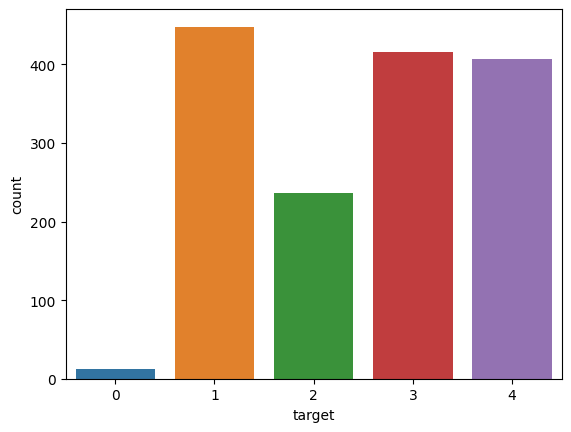

In [60]:
sns.countplot(x="target", data=df2)

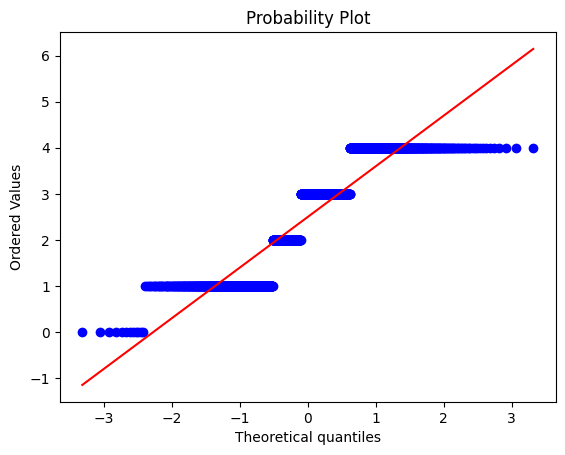

In [61]:
measurements = df2['target']
stats.probplot(measurements, dist="norm", plot=pylab)
pylab.show()

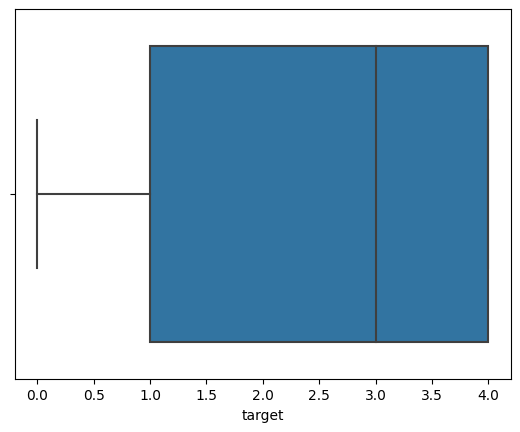

In [62]:
ax = sns.boxplot(x=measurements)

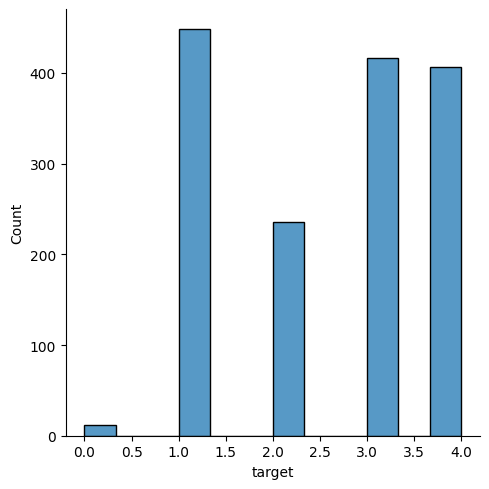

In [63]:
ax = sns.displot(measurements)

C:\Users\МОиБД\AppData\Local\Temp\ipykernel_14948\3406331038.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df2['target'],color='red',label='target',ax=ax)


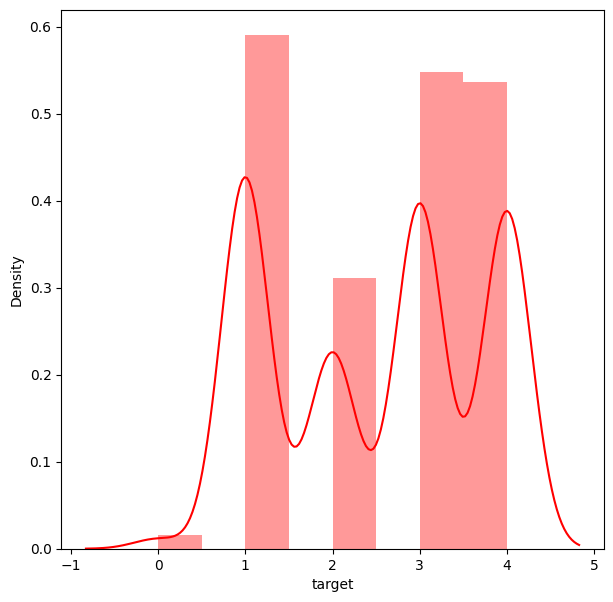

In [66]:
import matplotlib.pyplot as plt
fig = plt.figure
fig,ax= plt.subplots(figsize=(7,7))
sns.distplot(df2['target'],color='red',label='target',ax=ax)
plt.show()

На основе данных графика можно сделать вывод, что значения целевой переменной не подчиняются нормальному закону распределения так как имеет раздельные кластеры c положительной ассиметрией

In [69]:
from scipy.stats import shapiro
stat, p = shapiro(measurements)
print('stat=%.3f, p=%.3f\n' % (stat, p))
if p > 0.05:
    print('Probaly Gaussian')
else:
    print('Probably not Gaussian')

stat=0.846, p=0.000

Probably not Gaussian


In [70]:
df3 = df2.copy()

In [71]:
df3["date"] = df["date_publish"]

In [72]:
df3.head()

name_company rating_company date_publish  \
0  Cybersport.Metaratings           None    8 декабря   
1         ESforce Holding           None    8 декабря   
2         ESforce Holding           None      29 июля   
3         ESforce Holding           None       9 июля   
4         ESforce Holding           None    11 апреля   

                                                text  \
0  7 декабря состоялась церемония награждения лау...   
1  7 декабря состоялась церемония награждения лау...   
2  Из совместного исследования издателя компьютер...   
3  По статистике The Esports Observer за I полови...   
4  Компании SuperData Research и PayPal провели с...   

                                          prep_text2  \
0  [декабрь, состояться, церемония, награждение, ...   
1  [декабрь, состояться, церемония, награждение, ...   
2  [совместный, исследование, издатель, компьютер...   
3  [статистика, половина, год, впервые, топ, самы...   
4  [компания, провести, совместный, исследование,...   

                                          prep_text3  \
0  [(декабрь, СУЩ,неод,мр ед,вн), (состояться, ИН...   
1  [(декабрь, СУЩ,неод,мр ед,вн), (состояться, ИН...   
2  [(совместный, ПРИЛ,кач неод,мр,ед,вн), (исслед...   
3  [(статистика, СУЩ,неод,жр ед,им), (половина, С...   
4  [(компания, СУЩ,неод,жр ед,им), (провести, ИНФ...   

                                              vector  target       date  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       0  8 декабря  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       0  8 декабря  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       0    29 июля  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       0     9 июля  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       0  11 апреля

In [73]:
for i in range(len(df3["date"])):
    if len(df3["date"][i].split()) > 1:
        if df3["date"][i].split()[1] == "янв":
            df3["date"][i] = df3["date"][i].split()[0] + " " + "января"
        if df3["date"][i].split()[1] == "фев":
            df3["date"][i] = df3["date"][i].split()[0] + " " + "февраля"
        if df3["date"][i].split()[1] == "мар":
            df3["date"][i] = df3["date"][i].split()[0] + " " + "марта"
        if df3["date"][i].split()[1] == "апр":
            df3["date"][i] = df3["date"][i].split()[0] + " " + "апреля"
        if df3["date"][i].split()[1] == "мая":
            df3["date"][i] = df3["date"][i].split()[0]  + " " +  "мая"
        if df3["date"][i].split()[1] == "июн":
            df3["date"][i] = df3["date"][i].split()[0] + " " + "июня"
        if df3["date"][i].split()[1] == "июл":
            df3["date"][i] = df3["date"][i].split()[0] + " " + "июля"
        if df3["date"][i].split()[1] == "авг":
            df3["date"][i] = df3["date"][i].split()[0] + " " + "августа"
        if df3["date"][i].split()[1] == "сен":
            df3["date"][i] = df3["date"][i].split()[0] + " " + "сентября"
        if df3["date"][i].split()[1] == "окт":
            df3["date"][i] = df3["date"][i].split()[0] + " " + "октября"
        if df3["date"][i].split()[1] == "ноя":
            df3["date"][i] = df3["date"][i].split()[0] + " " + "ноября"
        if df3["date"][i].split()[1] == "дек":
            df3["date"][i] = df3["date"][i].split()[0] + " " +  "декабря" 
        
        
    else:
        continue

C:\Users\МОиБД\AppData\Local\Temp\ipykernel_14948\433785712.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3["date"][i] = df3["date"][i].split()[0]  + " " +  "мая"
C:\Users\МОиБД\AppData\Local\Temp\ipykernel_14948\433785712.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3["date"][i] = df3["date"][i].split()[0] + " " + "марта"
C:\Users\МОиБД\AppData\Local\Temp\ipykernel_14948\433785712.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

In [74]:
daa = []
for i in df3["date"]:     
    if (i.split()[1] == "часов" or i.split()[1] == "в"):
        daa.append("мая")
    else:
        daa.append(i.split()[1])   

<AxesSubplot: ylabel='target'>

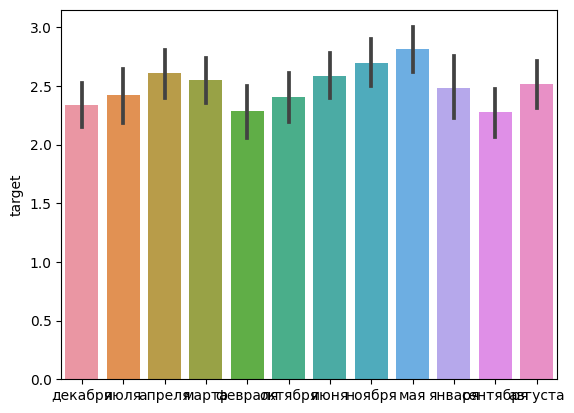

In [75]:
sns.barplot(x = daa, y = df3["target"], data=df3)

In [76]:
df3["reiting"] = df["rating_company"]

In [101]:
new_reiting = []
for i in df3["reiting"]:
    if (i is not None):
        new_reiting.append(float(i))
    else:
        new_reiting.append(i)

In [102]:
df3["reiting"]=new_reiting

In [103]:
df3['reiting'].fillna(df3['reiting'].mean(), inplace = True)

In [104]:
df3.head()

name_company rating_company date_publish  \
0  Cybersport.Metaratings           None    8 декабря   
1         ESforce Holding           None    8 декабря   
2         ESforce Holding           None      29 июля   
3         ESforce Holding           None       9 июля   
4         ESforce Holding           None    11 апреля   

                                                text  \
0  7 декабря состоялась церемония награждения лау...   
1  7 декабря состоялась церемония награждения лау...   
2  Из совместного исследования издателя компьютер...   
3  По статистике The Esports Observer за I полови...   
4  Компании SuperData Research и PayPal провели с...   

                                          prep_text2  \
0  [декабрь, состояться, церемония, награждение, ...   
1  [декабрь, состояться, церемония, награждение, ...   
2  [совместный, исследование, издатель, компьютер...   
3  [статистика, половина, год, впервые, топ, самы...   
4  [компания, провести, совместный, исследование,...   

                                          prep_text3  \
0  [(декабрь, СУЩ,неод,мр ед,вн), (состояться, ИН...   
1  [(декабрь, СУЩ,неод,мр ед,вн), (состояться, ИН...   
2  [(совместный, ПРИЛ,кач неод,мр,ед,вн), (исслед...   
3  [(статистика, СУЩ,неод,жр ед,им), (половина, С...   
4  [(компания, СУЩ,неод,жр ед,им), (провести, ИНФ...   

                                              vector  target       date  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       0  8 декабря   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       0  8 декабря   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       0    29 июля   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       0     9 июля   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       0  11 апреля   

     reiting  
0  91.397943  
1  91.397943  
2  91.397943  
3  91.397943  
4  91.397943

<AxesSubplot: xlabel='reiting', ylabel='target'>

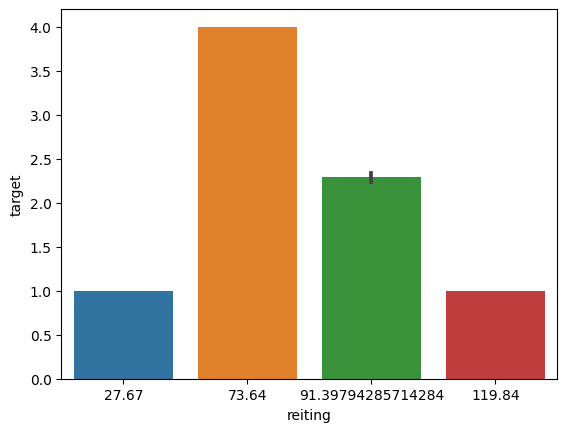

In [105]:
sns.barplot(x = df3["reiting"], y = df3["target"], data=df3)

In [106]:
df3["key_words"] = tfidf_words

<AxesSubplot: xlabel='key_words'>

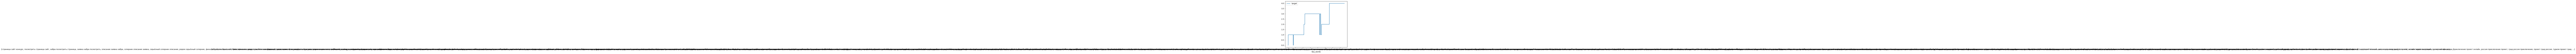

In [107]:
df3.plot(x = "key_words", y = "target")

In [108]:
df3["vector"] = df2["vector"]

In [78]:
df3.head()

name_company rating_company date_publish  \
0  Cybersport.Metaratings           None    8 декабря   
1         ESforce Holding           None    8 декабря   
2         ESforce Holding           None      29 июля   
3         ESforce Holding           None       9 июля   
4         ESforce Holding           None    11 апреля   

                                                text  \
0  7 декабря состоялась церемония награждения лау...   
1  7 декабря состоялась церемония награждения лау...   
2  Из совместного исследования издателя компьютер...   
3  По статистике The Esports Observer за I полови...   
4  Компании SuperData Research и PayPal провели с...   

                                          prep_text2  \
0  [декабрь, состояться, церемония, награждение, ...   
1  [декабрь, состояться, церемония, награждение, ...   
2  [совместный, исследование, издатель, компьютер...   
3  [статистика, половина, год, впервые, топ, самы...   
4  [компания, провести, совместный, исследование,...   

                                          prep_text3  \
0  [(декабрь, СУЩ,неод,мр ед,вн), (состояться, ИН...   
1  [(декабрь, СУЩ,неод,мр ед,вн), (состояться, ИН...   
2  [(совместный, ПРИЛ,кач неод,мр,ед,вн), (исслед...   
3  [(статистика, СУЩ,неод,жр ед,им), (половина, С...   
4  [(компания, СУЩ,неод,жр ед,им), (провести, ИНФ...   

                                              vector  target       date  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       0  8 декабря   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       0  8 декабря   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       0    29 июля   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       0     9 июля   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       0  11 апреля   

  reiting  
0    None  
1    None  
2    None  
3    None  
4    None

Из проведенных визуаализаций можно сделать вывод что у большинство номинаций статьи были сделаны в мае, у компаний с рейтингом 73.64

# 1.6 Отчет о проделанной работе

### 1.1 Парсинг данных

На основе имеющихся данных построен исходных набор данных, включающий название, описание, рейтинг, сферу деятельности компаний, дату публикации и текст статей. Набор не дополнен какими-либо другими данными. После построения набора данных был сделан вывод, что у большинства компаний нет информации ни на хабре, ни на предоставленных json файлах

### 1.2 Формирование структуры набора данных

При формировании структуры набора данных были выделены атрибуты с наибольшим влиянием на определение кластеров к ним относяться `название компании` и `текст статей компаний` данные атрибуты были оставленны для последующего обучения

### 1.3 Предварительная обработка текстовых данных

В качестве предварительной обработки текстовых данных были использованы методы NLP: токенизация, лемматизация, выделение частей речи, а также удаление стоп-слов, пунктуации, спецсимволов.

### 1.4 Поиск ключевых слов/n-грамм. Векторизация текстов

В качестве методов векторизации текста были выбраны следующие методы: 
- `Bag of Words` как один из наиболее простых и распространенных методов векторизации
- `TF-IDF` как улучшенная версия Bag of Words, которая учитывает не только количество вхождений слова в каждом документе, но и его частоту во всей коллекции документов
- `Word2Vec` имеющее возможность учитывать лингвистические свойства слов

После выполнения векторизации в набо данных были добавленны ключевые слова и его векторное представление

### 1.5 Разведочный анализ

Разведочный анализ показал на основе данных графика, что значения целевой переменной не подчиняются нормальному закону распределения, так как имеет раздельные кластеры

Были также проведены визуализации отражающие зависимости темы от временных признаков, от рейтинга, от ключевых слов в ходе которых был сделан вывод, что у большинства номинаций статьи были сделаны в мае, у компаний с рейтингом 73.64